In [2]:
import pandas as pd
import numpy as np

vals = np.array([[0, 1, 1, 2]])
relation = pd.DataFrame(vals, columns=["source","target","lag","weight"])

import networkx as nx

G = nx.DiGraph()
for _, row in relation.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

relation.to_csv('../Experiments/Sythetic_DAG_data/synth_data_back_door_relation.csv', index=False) 

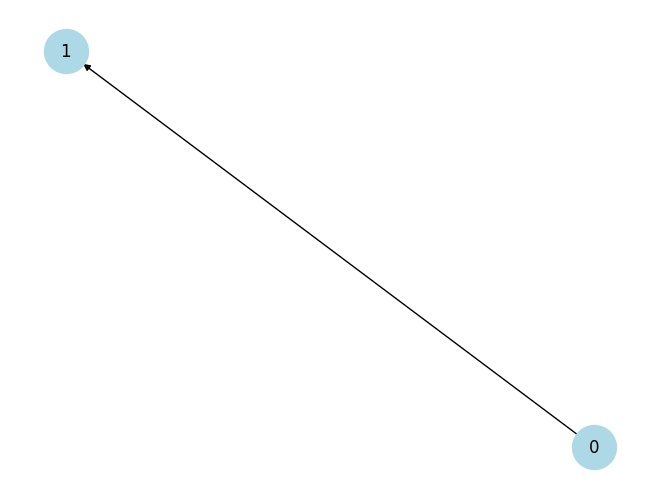

In [3]:
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True, node_color="lightblue", node_size=1000, font_size=12)
plt.show()

In [4]:
for i in G.nodes:
    print(i)

0
1


In [5]:
G[0][1]

{'weight': np.int64(2)}

In [6]:
seed = 0
T = 10000
np.random.seed(seed)
data = {node: np.random.normal(size=T) for node in G.nodes}
noise_std = 1

for t in range(1, 10000):
    for node in G.nodes:
        curr = node
        parents = list(G.predecessors(node))
        val = .5*data[node][t-1]
        for p in parents:
            w = G[p][curr]["weight"]  # use stored edge weight
            val += w * data[p][t-1]
        
        data[node][t] = val + np.random.normal(0, noise_std)

synth_data = pd.DataFrame(data)
#synth_data.to_csv('../Experiments/Sythetic_DAG_data/synth_data_back_door.csv', index=False)

In [24]:
seed = 0
np.random.seed(seed)
x_t = lambda x_t_1, e: .5*x_t_1 + e
y_t = lambda x_t_1, y_t_1, e: .5*y_t_1 + 2*x_t_1 + e

all_x = [np.random.normal(0,1)]
all_y = [np.random.normal(0,1)]

for t in range(1, 10000):
    all_x.append(x_t(all_x[-1], np.random.normal(0,1)))
    all_y.append(y_t(all_x[-1], all_y[-1], np.random.normal(0,1)))

cha = pd.DataFrame([all_x, all_y]).T

In [9]:
def theory_bounds(marg_x, marg_y, thres_x, thres_y):

    p_x = np.mean(marg_x >= thres_x, axis=0)
    p_x_ctf = 1 - p_x
    p_y_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x_ctf = p_y_and_x_ctf/p_x_ctf

    p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
    p_y_given_x = p_y_and_x/p_x

    #print(p_y_given_x)
    p_l = p_y_given_x_ctf/p_y_given_x

    p_y_ctf_and_x_ctf = np.mean((marg_x < thres_x) & (marg_y <= thres_y), axis=0)
    p_y_ctf_given_x_ctf = p_y_ctf_and_x_ctf/p_x_ctf

    p_r = p_y_ctf_given_x_ctf/p_y_given_x
    l_b = np.maximum(0, 1 - p_l)

    #right bound
    r_b = np.minimum(1, p_r)

    return l_b, r_b

In [25]:
window_size = 5
windows = np.lib.stride_tricks.sliding_window_view(cha.values, (window_size, cha.shape[1]))
# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, cha.shape[1])
marg_x = windows[:,:-1,0]
marg_y = windows[:,1:,1]

thres_x = 2
thres_y = 1

theory_bounds(marg_x, marg_y, thres_x, thres_y)

(array([0.62486531, 0.62486531, 0.62497183, 0.62498669]),
 array([0.64918964, 0.64918964, 0.64929615, 0.64937693]))

In [36]:
np.random.normal(0,1,size=(9996))

array([-1.69241716,  0.96897113,  1.37142344, ..., -0.76521842,
       -1.52699272,  1.05192317], shape=(9996,))

In [34]:
marg_y[:,-2]

array([8.39668585, 6.75156218, 6.18945211, ..., 7.08757229, 2.51904943,
       0.33607168], shape=(9996,))

In [40]:
np.mean(y_t(marg_x[:,-1], marg_y[:,-2], np.random.normal(0,1,size=(9996)))>thres_y)

np.float64(0.4001600640256102)

In [18]:
window_size = 5
windows = np.lib.stride_tricks.sliding_window_view(cha.values, (window_size, cha.shape[1]))
# Reshape to (num_windows, window_size, num_features)
windows = windows.reshape(-1, window_size, cha.shape[1])
marg_x = windows[:,:-1,0]
marg_y = windows[:,1:,1]


In [22]:
p_x = np.mean(marg_x >= thres_x, axis=0)
p_y_and_x = np.mean((marg_x >= thres_x) & (marg_y > thres_y), axis=0)
p_y_given_x = p_y_and_x/p_x

In [23]:
p_y_given_x

array([0.96724046, 0.96724046, 0.96724046, 0.96723967])

In [7]:
synth_data

,0,1
0,1.764052,-0.202117
1,1.212072,3.426566
2,1.424152,4.565641
3,-1.791871,5.251605
4,-0.088043,-0.355819
...,...,...
9995,0.308665,-3.192229
9996,-0.105202,-0.979208
9997,-0.636937,0.306801
9998,0.273570,-2.577673


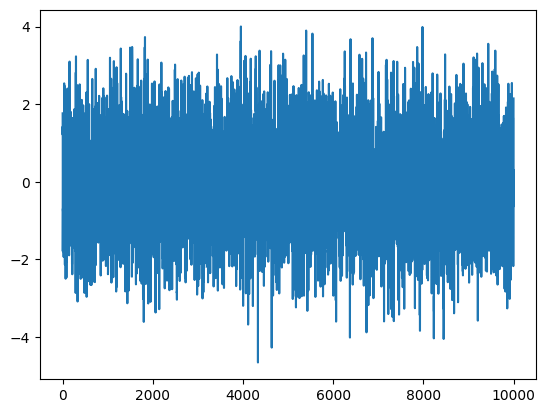

In [26]:
import matplotlib.pyplot as plt

plt.plot(synth_data[0.0])